In [1]:
import gymnasium as gym
import torch
import sys

In [2]:
env = gym.make_vec('CartPole-v1', num_envs = 4)

Checking out environments

In [3]:
env.observation_space

Box([[-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]], [[4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]], (4, 4), float32)

In [4]:
obs_sample = env.observation_space.sample()
obs_sample

array([[ 1.6448349 ,  0.5824261 ,  0.3927801 , -1.0263718 ],
       [ 2.5605235 ,  0.65262336, -0.4081317 ,  0.08522306],
       [ 1.479258  , -1.6061889 , -0.28395727,  1.5322659 ],
       [ 2.581557  ,  0.37197793, -0.18741928, -0.02470775]],
      dtype=float32)

In [5]:
obs_sample.shape

(4, 4)

In [6]:
env.action_space

MultiDiscrete([2 2 2 2])

In [7]:
actions_sample = env.action_space.sample()
actions_sample

array([1, 1, 0, 0])

In [8]:
states, info = env.reset()
states

array([[ 0.03492941,  0.02148944, -0.01351567,  0.01223867],
       [ 0.04804232,  0.04559997, -0.01459954, -0.03340603],
       [-0.03066042, -0.00774271, -0.03180776,  0.03279681],
       [ 0.00175442,  0.02547887, -0.01876951,  0.00993725]],
      dtype=float32)

In [9]:
next_states, rewards, dones, terminated, _ = env.step(actions_sample)

In [10]:
next_states

array([[ 0.0353592 ,  0.2168026 , -0.01327089, -0.28467777],
       [ 0.04895432,  0.2409282 , -0.01526766, -0.33065927],
       [-0.03081527, -0.20239443, -0.03115182,  0.3152768 ],
       [ 0.00226399, -0.16936895, -0.01857076,  0.29663956]],
      dtype=float32)

In [11]:
rewards

array([1., 1., 1., 1.], dtype=float32)

In [12]:
dones # done is when state successfully finished or passed

array([False, False, False, False])

In [13]:
# test_dones = torch.from_numpy(dones)
# for i in range(test_dones.size().numel()):
#     print(test_dones[i])

In [14]:
terminated # terminated is when agent failed 

array([False, False, False, False])

Setting up networks

In [15]:
import random
import numpy as np
from src.ppo import Actor, Critic, Agent
from src.utils import train

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

/home/zhutchens/projects/RL/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [16]:
actor = Actor(4, 2, 128).to(device)
critic = Critic(4, 1, 128).to(device)

In [17]:
obs_sample = torch.from_numpy(obs_sample).to(device)
dist = actor.forward(obs_sample)
dist

Categorical(logits: torch.Size([4, 2]))

In [18]:
test_sample = dist.sample()

In [19]:
dist.log_prob(test_sample)

tensor([-0.6640, -0.7402, -0.6430, -0.6568], grad_fn=<SqueezeBackward1>)

In [20]:
dist.log_prob(test_sample).exp()

tensor([0.5148, 0.4770, 0.5257, 0.5185], grad_fn=<ExpBackward0>)

In [21]:
critic.forward(obs_sample)

tensor([[0.1003],
        [0.0094],
        [0.0519],
        [0.0382]], grad_fn=<AddmmBackward0>)

In [22]:
agent = Agent(actor, critic, 0.1, 0.99, 0.95, 0.0003, 0.0003, device, 32)

In [ ]:
train(env, agent, 300, 128, 4)

finished episode: 0
total reward: 489.0
number of steps: 128
---------------
finished episode: 1
total reward: 492.0
number of steps: 128
---------------
finished episode: 2
total reward: 495.0
number of steps: 128
---------------
finished episode: 3
total reward: 493.0
number of steps: 128
---------------
finished episode: 4
total reward: 490.0
number of steps: 128
---------------
finished episode: 5
total reward: 495.0
number of steps: 128
---------------
finished episode: 6
total reward: 491.0
number of steps: 128
---------------
finished episode: 7
total reward: 495.0
number of steps: 128
---------------
finished episode: 8
total reward: 495.0
number of steps: 128
---------------
finished episode: 9
total reward: 491.0
number of steps: 128
---------------
finished episode: 10
total reward: 490.0
number of steps: 128
---------------
finished episode: 11
total reward: 492.0
number of steps: 128
---------------
finished episode: 12
total reward: 493.0
number of steps: 128
------------

Text(0, 0.5, 'reward')

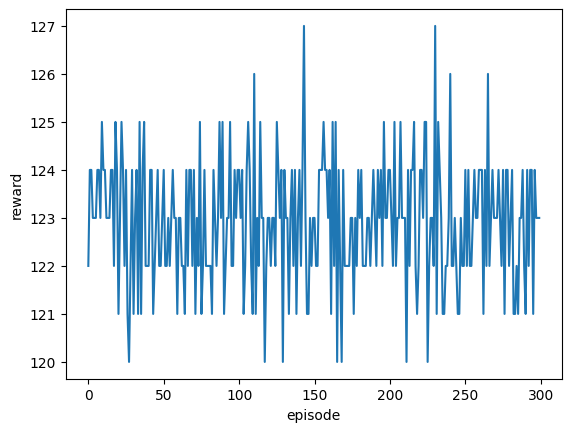

In [ ]:
import matplotlib.pyplot as plt
plt.plot(agent.all_rewards)
plt.xlabel('episode')
plt.ylabel('reward')    

In [ ]:
env.close()

In [ ]:
# eval_env = gym.make('CartPole-v1', render_mode = 'human')
eval_env = gym.make('CartPole-v1')

eval_rewards = 0
eval_episodes = 100
for i in range(eval_episodes):
    done, truncated = False, False
    state, _ = eval_env.reset()
    total_reward = 0

    while not (done or truncated):
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            dist = actor(state_t)
            action = dist.probs.argmax(dim = 1)
            state, reward, done, truncated, _ = eval_env.step(action.item())
            total_reward += reward

    print("evaluation reward:", total_reward)
    eval_rewards += total_reward

eval_env.close()
print('average reward:', eval_rewards / eval_episodes)

evaluation reward: 9.0
evaluation reward: 19.0
evaluation reward: 18.0
evaluation reward: 10.0
evaluation reward: 16.0
evaluation reward: 15.0
evaluation reward: 10.0
evaluation reward: 17.0
evaluation reward: 23.0
evaluation reward: 15.0
evaluation reward: 21.0
evaluation reward: 10.0
evaluation reward: 9.0
evaluation reward: 10.0
evaluation reward: 9.0
evaluation reward: 9.0
evaluation reward: 10.0
evaluation reward: 9.0
evaluation reward: 9.0
evaluation reward: 8.0
evaluation reward: 16.0
evaluation reward: 10.0
evaluation reward: 22.0
evaluation reward: 14.0
evaluation reward: 9.0
evaluation reward: 14.0
evaluation reward: 11.0
evaluation reward: 9.0
evaluation reward: 9.0
evaluation reward: 17.0
evaluation reward: 16.0
evaluation reward: 23.0
evaluation reward: 16.0
evaluation reward: 10.0
evaluation reward: 10.0
evaluation reward: 22.0
evaluation reward: 10.0
evaluation reward: 16.0
evaluation reward: 14.0
evaluation reward: 10.0
evaluation reward: 16.0
evaluation reward: 20.0
ev

In [ ]:
# agent.save_agent()